In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ./dataset
!mkdir ./dataset/origin
!mkdir ./dataset/input
!mkdir ./dataset/target
!unzip /content/drive/MyDrive/archive.zip -d ./dataset/origin

Archive:  /content/drive/MyDrive/archive.zip
  inflating: ./dataset/origin/00000000.jpg  
  inflating: ./dataset/origin/00000000_(2).jpg  
  inflating: ./dataset/origin/00000000_(3).jpg  
  inflating: ./dataset/origin/00000000_(4).jpg  
  inflating: ./dataset/origin/00000000_(5).jpg  
  inflating: ./dataset/origin/00000000_(6).jpg  
  inflating: ./dataset/origin/00000000_(7).jpg  
  inflating: ./dataset/origin/00000001.jpg  
  inflating: ./dataset/origin/00000001_(2).jpg  
  inflating: ./dataset/origin/00000001_(3).jpg  
  inflating: ./dataset/origin/00000001_(4).jpg  
  inflating: ./dataset/origin/00000001_(5).jpg  
  inflating: ./dataset/origin/00000001_(6).jpg  
  inflating: ./dataset/origin/00000001_(7).jpg  
  inflating: ./dataset/origin/00000002.jpg  
  inflating: ./dataset/origin/00000002_(2).jpg  
  inflating: ./dataset/origin/00000002_(3).jpg  
  inflating: ./dataset/origin/00000002_(4).jpg  
  inflating: ./dataset/origin/00000002_(5).jpg  
  inflating: ./dataset/origin/000000

In [ ]:
!pip install cmapy

  Created wheel for cmapy: filename=cmapy-0.6.6-py3-none-any.whl size=3958 sha256=064e698d4567215a1ff5e1c49b257caed2f497f6fb6c24428bb004ddf649ade1
  Stored in directory: /root/.cache/pip/wheels/49/9a/c8/486d47fd07a9ca1b91602dd040f727313dbeaa059a45d77521
Successfully built cmapy


In [ ]:
from PIL import Image
import numpy as np
import glob
import cv2
import os
import cmapy

path = 'dataset/origin/'

for filename in os.listdir(path):
  img = Image.open(path+filename)

  h, w = img.height, img.width
  img = np.array(img)

  overlay = img.copy()
  target = np.zeros((h,w))

  #max_r = min(h,w)//6
  alpha = np.random.randint(10,25)/100

  for _ in range(np.random.randint(1,10)):
    x = np.random.randint(30,w-30)
    y = np.random.randint(30,h-30)
    center = (x, y)
    l = np.random.randint(15,50)
    rgb = cmapy.color('viridis', np.random.randint(0,256), rgb_order=True)

    ellipse_float = (center, (l, (np.random.randint(50,90)/100)*l), np.random.randint(-10,11))
    cv2.ellipse(overlay, ellipse_float, rgb, -1)
    cv2.ellipse(target, ellipse_float, 1, -1)

  img = cv2.addWeighted(overlay, alpha, img, 1-alpha, 0)
  img = Image.fromarray(img)
  target = Image.fromarray(np.uint8(target)*255)

  if img.mode in ("RGBA", "P"):
    img = img.convert("RGB")

  img.save('dataset/input/'+filename)
  target.save('dataset/target/'+filename)

In [ ]:
#CUDA_LAUNCH_BLOCKING = "1"

import torch
from skimage.io import imread
from torch.utils import data
from tqdm import tqdm


class SegmentationDataSet(data.Dataset):
    """Image segmentation dataset with caching, pretransforms and multiprocessing."""

    def __init__(
        self,
        inputs: list,
        targets: list,
        transform=None,
        use_cache=False,
        pre_transform=None,
    ):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long
        self.use_cache = use_cache
        self.pre_transform = pre_transform

        if self.use_cache:
            from itertools import repeat
            from multiprocessing import Pool

            with Pool() as pool:
                self.cached_data = pool.starmap(
                    self.read_images, zip(inputs, targets, repeat(self.pre_transform))
                )

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index: int):
        if self.use_cache:
            x, y = self.cached_data[index]
        else:
            # Select the sample
            input_ID = self.inputs[index]
            target_ID = self.targets[index]

            # Load input and target
            x, y = imread(str(input_ID)), imread(str(target_ID))

        # Preprocessing
        if self.transform is not None:
            x, y = self.transform(x, y)

        # Typecasting
        x, y = torch.from_numpy(x).type(self.inputs_dtype), torch.from_numpy(y).type(
            self.targets_dtype
        )

        return x, y

    @staticmethod
    def read_images(inp, tar, pre_transform):
        inp, tar = imread(str(inp)), imread(str(tar))
        if pre_transform:
            inp, tar = pre_transform(inp, tar)
        return inp, tar

In [ ]:
from typing import List, Callable, Tuple

import numpy as np
import albumentations as A
from sklearn.externals._pilutil import bytescale
from skimage.util import crop
from skimage.filters import threshold_otsu


def normalize_01(inp: np.ndarray):
    """Squash image input to the value range [0, 1] (no clipping)"""
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out


def normalize(inp: np.ndarray, mean: float, std: float):
    """Normalize based on mean and standard deviation."""
    inp_out = (inp - mean) / std
    return inp_out


def create_dense_target(tar: np.ndarray):
    classes = np.unique(tar)
    dummy = np.zeros_like(tar)
    for idx, value in enumerate(classes):
        mask = np.where(tar == value)
        dummy[mask] = idx

    return dummy


def center_crop_to_size(x: np.ndarray,
                        size: Tuple,
                        copy: bool = False,
                        ) -> np.ndarray:
    """
    Center crops a given array x to the size passed in the function.
    Expects even spatial dimensions!
    """
    x_shape = np.array(x.shape)
    size = np.array(size)
    params_list = ((x_shape - size) / 2).astype(np.int).tolist()
    params_tuple = tuple([(i, i) for i in params_list])
    cropped_image = crop(x, crop_width=params_tuple, copy=copy)
    return cropped_image


def re_normalize(inp: np.ndarray,
                 low: int = 0,
                 high: int = 255
                 ):
    """Normalize the data to a certain range. Default: [0-255]"""
    inp_out = bytescale(inp, low=low, high=high)
    return inp_out


def random_flip(inp: np.ndarray, tar: np.ndarray, ndim_spatial: int):
    flip_dims = [np.random.randint(low=0, high=2) for dim in range(ndim_spatial)]

    flip_dims_inp = tuple([i + 1 for i, element in enumerate(flip_dims) if element == 1])
    flip_dims_tar = tuple([i for i, element in enumerate(flip_dims) if element == 1])

    inp_flipped = np.flip(inp, axis=flip_dims_inp)
    tar_flipped = np.flip(tar, axis=flip_dims_tar)

    return inp_flipped, tar_flipped


def binary_filter(tar: np.ndarray):
  thresh = threshold_otsu(tar)
  binary = tar > thresh

  return binary


class Repr:
    """Evaluable string representation of an object"""

    def __repr__(self): return f'{self.__class__.__name__}: {self.__dict__}'


class FunctionWrapperSingle(Repr):
    """A function wrapper that returns a partial for input only."""

    def __init__(self, function: Callable, *args, **kwargs):
        from functools import partial
        self.function = partial(function, *args, **kwargs)

    def __call__(self, inp: np.ndarray): return self.function(inp)


class FunctionWrapperDouble(Repr):
    """A function wrapper that returns a partial for an input-target pair."""

    def __init__(self, function: Callable, input: bool = True, target: bool = False, *args, **kwargs):
        from functools import partial
        self.function = partial(function, *args, **kwargs)
        self.input = input
        self.target = target

    def __call__(self, inp: np.ndarray, tar: dict):
        if self.input: inp = self.function(inp)
        if self.target: tar = self.function(tar)
        return inp, tar


class Compose:
    """Baseclass - composes several transforms together."""

    def __init__(self, transforms: List[Callable]):
        self.transforms = transforms

    def __repr__(self): return str([transform for transform in self.transforms])


class ComposeDouble(Compose):
    """Composes transforms for input-target pairs."""

    def __call__(self, inp: np.ndarray, target: dict):
        for t in self.transforms:
            inp, target = t(inp, target)
        return inp, target


class ComposeSingle(Compose):
    """Composes transforms for input only."""

    def __call__(self, inp: np.ndarray):
        for t in self.transforms:
            inp = t(inp)
        return inp


class AlbuSeg2d(Repr):
    """
    Wrapper for albumentations' segmentation-compatible 2D augmentations.
    Wraps an augmentation so it can be used within the provided transform pipeline.
    See https://github.com/albu/albumentations for more information.
    Expected input: (C, spatial_dims)
    Expected target: (spatial_dims) -> No (C)hannel dimension
    """
    def __init__(self, albumentation: Callable):
        self.albumentation = albumentation

    def __call__(self, inp: np.ndarray, tar: np.ndarray):
        # input, target
        out_dict = self.albumentation(image=inp, mask=tar)
        input_out = out_dict['image']
        target_out = out_dict['mask']

        return input_out, target_out

In [ ]:
# Imports
import pathlib
import torch

import albumentations
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from skimage.transform import resize


# root directory
root = pathlib.Path.cwd() / 'dataset'


def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames


# input and target files
inputs = get_filenames_of_path(root / 'input')
targets = get_filenames_of_path(root / 'target')

pre_transforms = ComposeDouble([
    FunctionWrapperDouble(resize,
                          input=True,
                          target=False,
                          output_shape=(256, 256, 3)),
    FunctionWrapperDouble(resize,
                          input=False,
                          target=True,
                          output_shape=(256, 256),
                          order=0,
                          anti_aliasing=False,
                          preserve_range=True),
    FunctionWrapperDouble(binary_filter,
                          input=False,
                          target=True),
])

# training transformations and augmentations
transforms_training = ComposeDouble([
    AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)

])

# validation transformations
transforms_validation = ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    inputs,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    targets,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

# inputs_train, inputs_valid = inputs[:80], inputs[80:]
# targets_train, targets_valid = targets[:80], targets[:80]

# dataset training
dataset_train = SegmentationDataSet(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=transforms_training,
                                    use_cache=True,
                                    pre_transform=pre_transforms)

# dataset validation
dataset_valid = SegmentationDataSet(inputs=inputs_valid,
                                    targets=targets_valid,
                                    transform=transforms_validation,
                                    use_cache=True,
                                    pre_transform=pre_transforms)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train, batch_size=2, shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid, batch_size=2, shuffle=True)

In [ ]:
from torch import nn
import torch


@torch.jit.script
def autocrop(encoder_layer: torch.Tensor, decoder_layer: torch.Tensor):
    """
    Center-crops the encoder_layer to the size of the decoder_layer,
    so that merging (concatenation) between levels/blocks is possible.
    This is only necessary for input sizes != 2**n for 'same' padding and always required for 'valid' padding.
    """
    if encoder_layer.shape[2:] != decoder_layer.shape[2:]:
        ds = encoder_layer.shape[2:]
        es = decoder_layer.shape[2:]
        assert ds[0] >= es[0]
        assert ds[1] >= es[1]
        if encoder_layer.dim() == 4:  # 2D
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2)
                            ]
        elif encoder_layer.dim() == 5:  # 3D
            assert ds[2] >= es[2]
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2),
                            ((ds[2] - es[2]) // 2):((ds[2] + es[2]) // 2),
                            ]
    return encoder_layer, decoder_layer


def conv_layer(dim: int):
    if dim == 3:
        return nn.Conv3d
    elif dim == 2:
        return nn.Conv2d


def get_conv_layer(in_channels: int,
                   out_channels: int,
                   kernel_size: int = 3,
                   stride: int = 1,
                   padding: int = 1,
                   bias: bool = True,
                   dim: int = 2):
    return conv_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                           bias=bias)


def conv_transpose_layer(dim: int):
    if dim == 3:
        return nn.ConvTranspose3d
    elif dim == 2:
        return nn.ConvTranspose2d


def get_up_layer(in_channels: int,
                 out_channels: int,
                 kernel_size: int = 2,
                 stride: int = 2,
                 dim: int = 3,
                 up_mode: str = 'transposed',
                 ):
    if up_mode == 'transposed':
        return conv_transpose_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
    else:
        return nn.Upsample(scale_factor=2.0, mode=up_mode)


def maxpool_layer(dim: int):
    if dim == 3:
        return nn.MaxPool3d
    elif dim == 2:
        return nn.MaxPool2d


def get_maxpool_layer(kernel_size: int = 2,
                      stride: int = 2,
                      padding: int = 0,
                      dim: int = 2):
    return maxpool_layer(dim=dim)(kernel_size=kernel_size, stride=stride, padding=padding)


def get_activation(activation: str):
    if activation == 'relu':
        return nn.ReLU()
    elif activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)
    elif activation == 'elu':
        return nn.ELU()


def get_normalization(normalization: str,
                      num_channels: int,
                      dim: int):
    if normalization == 'batch':
        if dim == 3:
            return nn.BatchNorm3d(num_channels)
        elif dim == 2:
            return nn.BatchNorm2d(num_channels)
    elif normalization == 'instance':
        if dim == 3:
            return nn.InstanceNorm3d(num_channels)
        elif dim == 2:
            return nn.InstanceNorm2d(num_channels)
    elif 'group' in normalization:
        num_groups = int(normalization.partition('group')[-1])  # get the group size from string
        return nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)


class Concatenate(nn.Module):
    def __init__(self):
        super(Concatenate, self).__init__()

    def forward(self, layer_1, layer_2):
        x = torch.cat((layer_1, layer_2), 1)

        return x


class DownBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 MaxPool.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 pooling: bool = True,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: str = 2,
                 conv_mode: str = 'same'):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation

        # conv layers
        self.conv1 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # pooling layer
        if self.pooling:
            self.pool = get_maxpool_layer(kernel_size=2, stride=2, padding=0, dim=self.dim)

        # activation layers
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

    def forward(self, x):
        y = self.conv1(x)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # activation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2

        before_pooling = y  # save the outputs before the pooling operation
        if self.pooling:
            y = self.pool(y)  # pooling
        return y, before_pooling


class UpBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 UpConvolution/Upsample.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: int = 3,
                 conv_mode: str = 'same',
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation
        self.up_mode = up_mode

        # upconvolution/upsample layer
        self.up = get_up_layer(self.in_channels, self.out_channels, kernel_size=2, stride=2, dim=self.dim,
                               up_mode=self.up_mode)

        # conv layers
        self.conv0 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=1, stride=1, padding=0,
                                    bias=True, dim=self.dim)
        self.conv1 = get_conv_layer(2 * self.out_channels, self.out_channels, kernel_size=3, stride=1,
                                    padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # activation layers
        self.act0 = get_activation(self.activation)
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm0 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

        # concatenate layer
        self.concat = Concatenate()

    def forward(self, encoder_layer, decoder_layer):
        """ Forward pass
        Arguments:
            encoder_layer: Tensor from the encoder pathway
            decoder_layer: Tensor from the decoder pathway (to be up'd)
        """
        up_layer = self.up(decoder_layer)  # up-convolution/up-sampling
        cropped_encoder_layer, dec_layer = autocrop(encoder_layer, up_layer)  # cropping

        if self.up_mode != 'transposed':
            # We need to reduce the channel dimension with a conv layer
            up_layer = self.conv0(up_layer)  # convolution 0
        up_layer = self.act0(up_layer)  # activation 0
        if self.normalization:
            up_layer = self.norm0(up_layer)  # normalization 0

        merged_layer = self.concat(up_layer, cropped_encoder_layer)  # concatenation
        y = self.conv1(merged_layer)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # acivation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2
        return y


class UNet(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 out_channels: int = 2,
                 n_blocks: int = 4,
                 start_filters: int = 32,
                 activation: str = 'relu',
                 normalization: str = 'batch',
                 conv_mode: str = 'same',
                 dim: int = 2,
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_blocks = n_blocks
        self.start_filters = start_filters
        self.activation = activation
        self.normalization = normalization
        self.conv_mode = conv_mode
        self.dim = dim
        self.up_mode = up_mode

        self.down_blocks = []
        self.up_blocks = []

        # create encoder path
        for i in range(self.n_blocks):
            num_filters_in = self.in_channels if i == 0 else num_filters_out
            num_filters_out = self.start_filters * (2 ** i)
            pooling = True if i < self.n_blocks - 1 else False

            down_block = DownBlock(in_channels=num_filters_in,
                                   out_channels=num_filters_out,
                                   pooling=pooling,
                                   activation=self.activation,
                                   normalization=self.normalization,
                                   conv_mode=self.conv_mode,
                                   dim=self.dim)

            self.down_blocks.append(down_block)

        # create decoder path (requires only n_blocks-1 blocks)
        for i in range(n_blocks - 1):
            num_filters_in = num_filters_out
            num_filters_out = num_filters_in // 2

            up_block = UpBlock(in_channels=num_filters_in,
                               out_channels=num_filters_out,
                               activation=self.activation,
                               normalization=self.normalization,
                               conv_mode=self.conv_mode,
                               dim=self.dim,
                               up_mode=self.up_mode)

            self.up_blocks.append(up_block)

        # final convolution
        self.conv_final = get_conv_layer(num_filters_out, self.out_channels, kernel_size=1, stride=1, padding=0,
                                         bias=True, dim=self.dim)

        # add the list of modules to current module
        self.down_blocks = nn.ModuleList(self.down_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)

        # initialize the weights
        self.initialize_parameters()

    @staticmethod
    def weight_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.weight, **kwargs)  # weights

    @staticmethod
    def bias_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.bias, **kwargs)  # bias

    def initialize_parameters(self,
                              method_weights=nn.init.xavier_uniform_,
                              method_bias=nn.init.zeros_,
                              kwargs_weights={},
                              kwargs_bias={}
                              ):
        for module in self.modules():
            self.weight_init(module, method_weights, **kwargs_weights)  # initialize weights
            self.bias_init(module, method_bias, **kwargs_bias)  # initialize bias

    def forward(self, x: torch.tensor):
        encoder_output = []

        # Encoder pathway
        for module in self.down_blocks:
            x, before_pooling = module(x)
            encoder_output.append(before_pooling)

        # Decoder pathway
        for i, module in enumerate(self.up_blocks):
            before_pool = encoder_output[-(i + 2)]
            x = module(before_pool, x)

        x = self.conv_final(x)

        return x

    def __repr__(self):
        attributes = {attr_key: self.__dict__[attr_key] for attr_key in self.__dict__.keys() if '_' not in attr_key[0] and 'training' not in attr_key}
        d = {self.__class__.__name__: attributes}
        return f'{d}'

In [ ]:
import numpy as np
import torch


class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.batch()  # learning rate scheduler step
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass

            loss = self.criterion(out, target)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()

In [ ]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# model
model = UNet(in_channels=3,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

# criterion
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.BCELoss()
#criterion = torch.nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  lr_scheduler=None,
                  epochs=60,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

model_name =  'flare_model.pt'
torch.save(model.state_dict(), pathlib.Path.cwd() / model_name)

In [ ]:
!unzip /content/drive/MyDrive/test.zip -d ./dataset

Archive:  /content/drive/MyDrive/test.zip
  inflating: ./dataset/IMG_1194.JPG  
  inflating: ./dataset/IMG_1195.JPG  
  inflating: ./dataset/IMG_1201.JPG  
  inflating: ./dataset/IMG_1276.JPG  
  inflating: ./dataset/IMG_1279.JPG  


In [ ]:
import pathlib

from skimage.io import imread
from skimage.transform import resize

# root directory
root = pathlib.Path.cwd() / 'dataset'
def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames

# input and target files
images_names = get_filenames_of_path(root)

# read images and store them in memory
images = [imread(img_name) for img_name in images_names]

# Resize images and targets
images_res = [resize(img, (256, 256, 3)) for img in images]
resize_kwargs = {'order': 0, 'anti_aliasing': False, 'preserve_range': True}

# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    torch.device('cpu')

# model
model = UNet(in_channels=3,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)


model_name = 'flare_model.pt'
model_weights = torch.load(pathlib.Path.cwd() / model_name)

model.load_state_dict(model_weights)

def predict(img,
            model,
            preprocess,
            postprocess,
            device,
            ):
    model.eval()
    img = preprocess(img)  # preprocess image
    x = torch.from_numpy(img).to(device)  # to torch, send to device
    with torch.no_grad():
        out = model(x)  # send through model/network

    out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
    result = postprocess(out_softmax)  # postprocess outputs

    return result

# preprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # typecasting to float32
    return img


# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim=1)  # perform argmax to generate 1 channel
    img = img.cpu().numpy()  # send to cpu and transform to numpy.ndarray
    img = np.squeeze(img)  # remove batch dim and channel dim -> [H, W]
    img = re_normalize(img)  # scale it to the range [0-255]
    return img

# predict the segmentation maps 
output = [predict(img, model, preprocess, postprocess, device) for img in images_res]

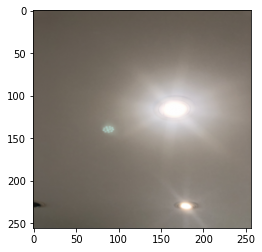

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images_res[3])

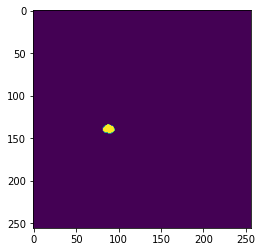

In [ ]:
plt.imshow(output[3])

In [ ]:
from matplotlib import cm

plt.imsave('4_1i.jpg', images_res[3])
plt.imsave('4_1t.jpg', output[3], cmap = cm.gray)

##image inpainting

#img = cv2.imread('origin.jpg')
#mask = cv2.imread('mask.jpg', 0)

#paint = cv2.inpaint(img, mask, 100, cv2.INPAINT_TELEA)

#cv2.imwrite('output.jpg', paint)

In [ ]:
def plot_training(training_losses,
                  validation_losses,
                  learning_rate,
                  gaussian=True,
                  sigma=2,
                  figsize=(8, 6)
                  ):
    """
    Returns a loss plot with training loss, validation loss and learning rate.
    """

    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    from scipy.ndimage import gaussian_filter

    list_len = len(training_losses)
    x_range = list(range(1, list_len + 1))  # number of x values

    fig = plt.figure(figsize=figsize)
    grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

    subfig1 = fig.add_subplot(grid[0, 0])
    subfig2 = fig.add_subplot(grid[0, 1])

    subfigures = fig.get_axes()

    for i, subfig in enumerate(subfigures, start=1):
        subfig.spines['top'].set_visible(False)
        subfig.spines['right'].set_visible(False)

    if gaussian:
        training_losses_gauss = gaussian_filter(training_losses, sigma=sigma)
        validation_losses_gauss = gaussian_filter(validation_losses, sigma=sigma)

        linestyle_original = '.'
        color_original_train = 'lightcoral'
        color_original_valid = 'lightgreen'
        color_smooth_train = 'red'
        color_smooth_valid = 'green'
        alpha = 0.25
    else:
        linestyle_original = '-'
        color_original_train = 'red'
        color_original_valid = 'green'
        alpha = 1.0

    # Subfig 1
    subfig1.plot(x_range, training_losses, linestyle_original, color=color_original_train, label='Training',
                 alpha=alpha)
    subfig1.plot(x_range, validation_losses, linestyle_original, color=color_original_valid, label='Validation',
                 alpha=alpha)
    if gaussian:
        subfig1.plot(x_range, training_losses_gauss, '-', color=color_smooth_train, label='Training', alpha=0.75)
        subfig1.plot(x_range, validation_losses_gauss, '-', color=color_smooth_valid, label='Validation', alpha=0.75)
    subfig1.title.set_text('Training & validation loss')
    subfig1.set_xlabel('Epoch')
    subfig1.set_ylabel('Loss')

    subfig1.legend(loc='upper right')

    # Subfig 2
    subfig2.plot(x_range, learning_rate, color='black')
    subfig2.title.set_text('Learning rate')
    subfig2.set_xlabel('Epoch')
    subfig2.set_ylabel('LR')

    return fig

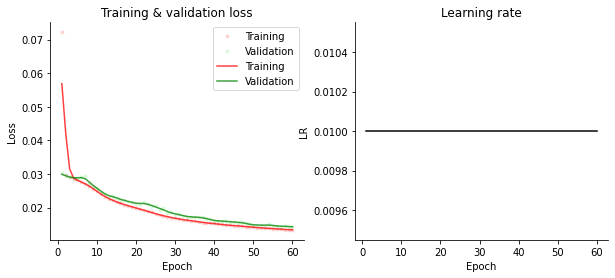

In [ ]:
fig = plot_training(training_losses,
                    validation_losses,
                    lr_rates,
                    gaussian=True,
                    sigma=1,
                    figsize=(10,4))